# Module 3 Project

<br> David Mauger
<br> Data Science - Full Time Immersive
<br> Date: Oct 28, 2019
<br> Howard Smith & Amanda Yandow
<br> https://github.com/Maugy

# Northwind Database & Hypothesis Testing

## Overview
1. [Objective & Background](#001)
2. [Obtaining Data & Defining Functions](#002)
3. [Question #1](#003)
4. [Question #2](#004)
5. [Question #3](#005)
6. [Question #4](#006)


<a id="001"></a>

## 1) Objective & Background
***


**1.1 Questions to Test:**
> 1) Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount? 
<br> 2) Does revenue have a statistically significant difference between regions?
<br> 3) Is there a statistically significant difference in efficiency (ship-to-order, late shipments) between shipping companies?
<br> 4) Is there a statistically significant difference between the best selling products per region?


**1.2 Data Provided:** 
>**Northwind Database**
<br> The Northwind database is a sample database used by Microsoft to demonstrate the features of some of its products. The database contains the sales data for Northwind Traders, a fictitious specialty foods export/import company.
<br>
<br>
>**Table Structure**
<img src="Northwind_ERD.png">


**1.3 Methodology**
<br> For each question listed above, I will follow a process that includes:

> - Explore Data
> - Define Hypothesis
> - Test Data
> - Interpret Data

I intend to use a variation of the OSEMN Process to address each question:  **Obtain Data, Scrub Data, Explore Data, Model Data, Interpret Data.**

<a id="002"></a>

## 2) Obtaining Data & Defining Functions
***

In [1]:
import sqlite3
import pandas as pd 
import sqlalchemy 

from sqlalchemy import create_engine
from sqlalchemy import inspect
from sqlalchemy.orm import Session, sessionmaker

import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from scipy import stats 

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as st
from scipy.stats import shapiro

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import warnings
warnings.filterwarnings('ignore') 

In [2]:
engine = create_engine("sqlite:///Northwind_small.sqlite")
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()


### Cohen's d

In [3]:
def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    
    return abs(d)

In [4]:
def evaluate_PDF(rv, x=4):
    
    mean = rv.mean()
    std = rv.std()
    xs = np.linspace(mean - x*std, mean + x*std, 100)
    ys = rv.pdf(xs)

    return xs, ys 

In [5]:
def overlap_superiority(group1, group2, n=1000):

    group1_sample = group1.rvs(n)
    group2_sample = group2.rvs(n)
    thresh = (group1.mean() + group2.mean()) / 2
    print(thresh)
    
    above = sum(group1_sample < thresh)
    below = sum(group2_sample > thresh)
    overlap = (above + below) / n
    superiority = sum(x > y for x, y in zip(group1_sample, group2_sample)) / n

    return overlap, superiority

In [6]:
def plot_pdfs(cohen_d=2):

    group1 = st.norm(0, 1)
    group2 = st.norm(cohen_d, 1)
    xs, ys = evaluate_PDF(group1)
    plt.fill_between(xs, ys, label='Group1', color='#ff2289', alpha=0.7)
    xs, ys = evaluate_PDF(group2)
    plt.fill_between(xs, ys, label='Group2', color='#376cb0', alpha=0.7)
    
    o, s = overlap_superiority(group1, group2)
    print('overlap', o)
    print('superiority', s)

### Central Limit Theorem

In [7]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample


In [8]:
def get_sample_mean(sample):
    return sum(sample) / len(sample)

In [9]:
def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist


<a id="003"></a>

## 3)  Question #1
> ### a) "Do discounts have a statistically significant effect on the number of products customers order?"
> ### b) "If so, at what level(s) of discount?"
***


**3.1** - [Define Hypothesis](#3.1) 
<br>**3.2** - [Explore Data](#3.2) 
<br>**3.3** - [Test Data](#3.3) 
<br>**3.4** - [Interpret Data](#3.4)
<br>


<a id="3.1"></a>

### 3.1 - Define Hypothesis

$H_O$: Discounts have **NO** significant effect on order quantity.<br> 
$H_a$: Discounts **HAVE** a significant effect on order quantity.<br> 
$\alpha$ = 0.05: The null hypothesis will be rejected if our P-value outcome is below this threshold.

<a id="3.2"></a>

### 3.2 - Explore Data

In [11]:
df_Order_Details = pd.read_sql_query("""SELECT * FROM OrderDetail;""", engine)

In [12]:
print(' Order Details Info \n')
print(df_Order_Details.info())
print('\n Order Details Description \n')
print(df_Order_Details.describe)
print('\n Order Details Shape \n')
print(df_Order_Details.shape)
print('\n Order Details Preview \n')
df_Order_Details.head()

 Order Details Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None

 Order Details Description 

<bound method NDFrame.describe of             Id  OrderId  ProductId  UnitPrice  Quantity  Discount
0     10248/11    10248         11      14.00        12      0.00
1     10248/42    10248         42       9.80        10      0.00
2     10248/72    10248         72      34.80         5      0.00
3     10249/14    10249         14      18.60         9      0.00
4     10249/51    10249         51      42.40        40      0.00
...        ...      ...        ...        ...       ...       ...
2150  11077/64    11077         64      33.25         2      0.03
2151  11

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<br> **No null values to account for.**
<br> **Drop columns 'ProductId' and 'OrderId' since they do not impact this particular question.**
<br>**Due to insufficient data, drop (0.01, 0.02, 0.03, 0.04, 0.06)** 
<br>

In [13]:
print('\n Null Values in "Discount": \n')
print(df_Order_Details.Discount.isna().sum())
print('\n Value Counts in "Discount":')
df_Order_Details.Discount.value_counts()


 Null Values in "Discount": 

0

 Value Counts in "Discount":


0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [14]:
print('\n Drop Columns in "Order Details": \n')
df_Order_Details = df_Order_Details.drop(['OrderId','Id'], axis=1)
df_Order_Details.head()


 Drop Columns in "Order Details": 



,ProductId,UnitPrice,Quantity,Discount
0,11,14.0,12,0.0
1,42,9.8,10,0.0
2,72,34.8,5,0.0
3,14,18.6,9,0.0
4,51,42.4,40,0.0


In [15]:
df_Discounts = (df_Order_Details['Discount']==0.00) | (df_Order_Details['Discount']==0.05) | (df_Order_Details['Discount']==0.10) | (df_Order_Details['Discount']==0.15) | (df_Order_Details['Discount']==0.20) | (df_Order_Details['Discount']==0.25)
df_updated = df_Order_Details.loc[df_Discounts]
print('\n Updated Discount Categories')
print(df_updated.Discount.value_counts())


 Updated Discount Categories
0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64


**Visualize Relationships**

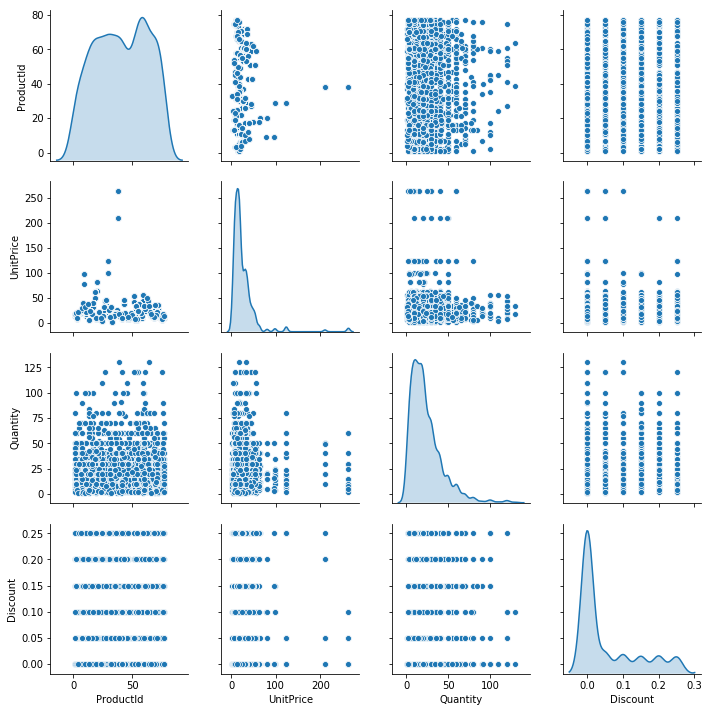

In [16]:
sns.pairplot(df_updated, diag_kind='kde');

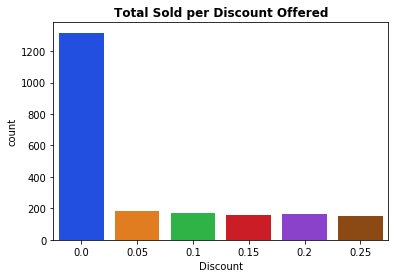

In [17]:
sns.countplot(x='Discount', data=df_updated, palette="bright");
plt.title('Total Sold per Discount Offered', fontweight='bold')
plt.show()

**EXAMINE OUTLIERS**


 Quantity per Discount Level 



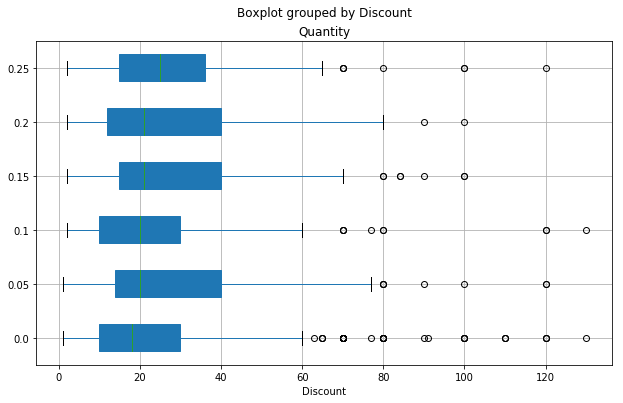

In [18]:
print('\n Quantity per Discount Level \n')
df_updated.boxplot('Quantity', by='Discount', vert=False, figsize =(10,6), patch_artist=True);

# fig, axs = plt.subplots()
# ax.set_title('Outliers in Discount')
# ax.set_xlabel('Quantity')
# ax.set_ylabel('Discount')
# ax  = fig.add_subplot(111)




In [19]:
df_updated.head()

,ProductId,UnitPrice,Quantity,Discount
0,11,14.0,12,0.0
1,42,9.8,10,0.0
2,72,34.8,5,0.0
3,14,18.6,9,0.0
4,51,42.4,40,0.0


In [20]:
avg_no_discount = df_updated[df_updated['Discount']==0].groupby('ProductId')['Quantity'].mean()
avg_discount = df_updated[df_updated['Discount']!=0].groupby('ProductId')['Quantity'].mean()

In [21]:
count_no_discount = df_updated[df_updated['Discount']==0].groupby('ProductId')['Quantity'].count()
count_discount = df_updated[df_updated['Discount']!=0].groupby('ProductId')['Quantity'].count()

In [22]:
df_updated

,ProductId,UnitPrice,Quantity,Discount
0,11,14.00,12,0.0
1,42,9.80,10,0.0
2,72,34.80,5,0.0
3,14,18.60,9,0.0
4,51,42.40,40,0.0
...,...,...,...,...
2147,52,7.00,2,0.0
2148,55,24.00,2,0.0
2151,66,17.00,1,0.0
2153,75,7.75,4,0.0


<a id="3.3"></a>

### 3.3 - Test Data

### Shapiro Test for Normality

In [23]:
st.shapiro(avg_no_discount)
statistic, p = shapiro(avg_no_discount)
print('Statistics=%.3f, p=%.3f' % (statistic, p))
alpha = .05
if p > alpha:
    print('Non-discounted data looks normal')
else:
    print('Non-discounted data does not look normal')

Statistics=0.942, p=0.002
Non-discounted data does not look normal


In [24]:
st.shapiro(avg_discount)
statistic, p = shapiro(avg_discount)
print('Statistics=%.3f, p=%.3f' % (statistic, p))
alpha = .05
if p > alpha:
    print('Discounted data looks normal')
else:
    print('Discounted data does not look normal')

Statistics=0.991, p=0.842
Discounted data looks normal


Average Orders - No Discounts: 21.811678528213182
Average Order - Discounts: 26.719231131216272


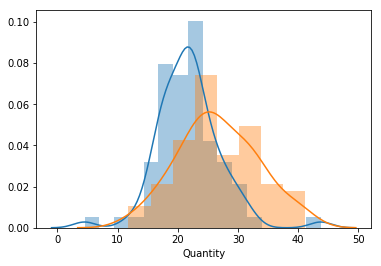

In [25]:
sns.distplot(avg_no_discount, label='Mean - No Discount');
sns.distplot(avg_discount, label='Mean - Discount');
print('Average Orders - No Discounts:', avg_no_discount.mean())
print('Average Order - Discounts:', avg_discount.mean())

In [26]:
k2, p = st.normaltest(avg_no_discount)
print("p = {:g}".format(p))
alpha = 0.05
if p > alpha:  
    print('Data looks normal')
else:
    print('Data does not look normal')

p = 0.000155827
Data does not look normal


In [27]:
k2, p = st.normaltest(avg_discount)
print("p = {:g}".format(p))
alpha = 0.05
if p > alpha:  
    print('Data looks normal')
else:
    print('Data does not look normal')

p = 0.782773
Data looks normal


### Apply Central Limit Theorem

In [28]:
# Due to lack of normality and outliers in No Discount, we will apply the Central Limit Theorem.

test_sample = get_sample(avg_no_discount, 30)
print(test_sample[:5]) 

[20.833333333333332, 30.0, 19.045454545454547, 28.166666666666668, 19.043478260869566]


In [29]:
test_sample2 = get_sample(avg_no_discount, 30)
test_sample2_mean = get_sample_mean(test_sample2)
print(test_sample2_mean) 

23.50507269283181


In [30]:
test_sample_dist = create_sample_distribution(avg_no_discount)
print(test_sample_dist[:5]) 

[21.608992074320614, 21.733499527740523, 21.189171232694484, 22.35048833861706, 22.545679260085066]


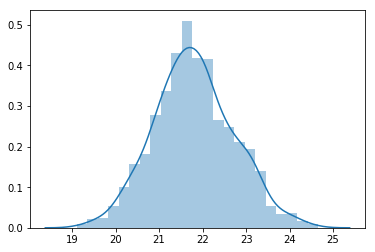

In [31]:
sample_dist_1000 = create_sample_distribution(avg_no_discount, 1000, 30)
sns.distplot(sample_dist_1000);

### Welch's T-Test

In [32]:
t_stat, p = stats.ttest_ind(avg_no_discount, avg_discount, equal_var=False)

print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')


Reject Null Hypothesis


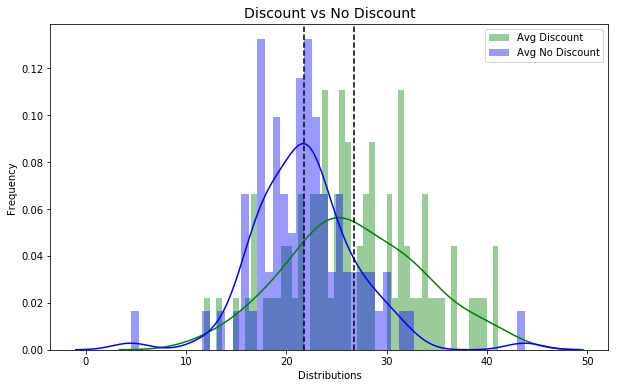

In [33]:
def visualization(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Avg Discount', color='green')
    sns.distplot(control, bins=50,  label='Avg No Discount', color='blue')

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')

    plt.title('Discount vs No Discount', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
visualization(avg_no_discount, avg_discount)

### ANOVA Test

In [34]:
formula = 'Quantity ~ Discount'
lm = ols(formula, df_updated).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
Discount,12621.238965,1.0,35.487951,2.991487e-09
Residual,762866.181622,2145.0,NaN,NaN


### Cohen's d

Interpreting  𝑑 
Most people don't have a good sense of how big  𝑑=2.0  is. If you are having trouble visualizing what the result of Cohen’s D means, use these general “rule of thumb” guidelines (which Cohen said should be used cautiously):

Small effect = 0.2

Medium Effect = 0.5

Large Effect = 0.8

In [35]:
d = Cohen_d(avg_no_discount, avg_discount)
print("Cohen's d:", d)


Cohen's d: 0.8202467909418832


0.4101233954709416
overlap 1.352
superiority 0.268


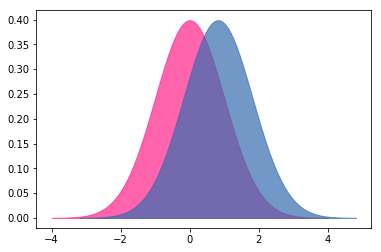

In [36]:
plot_pdfs(d)

> ### b) "Is there a difference between discount levels?"

$H_O$: There is **NO** significant difference between discount levels.<br> 
$H_a$: There **IS** a significant effect between discount levels.<br> 
$\alpha$ = 0.05: The null hypothesis will be rejected if our P-value outcome is below this threshold.

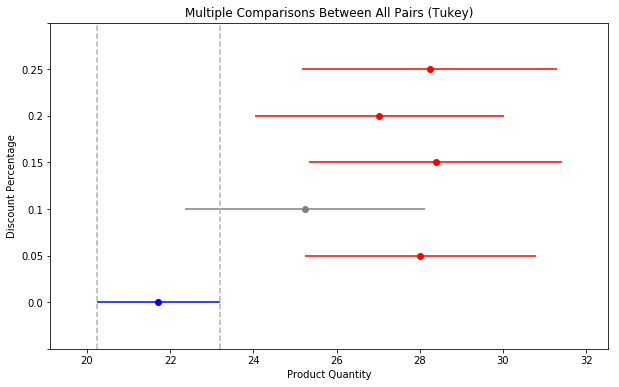

In [37]:
mc_updated = MultiComparison(df_updated.Quantity, df_updated.Discount)
mc_upd = mc_updated.tukeyhsd()
mc_upd.plot_simultaneous(comparison_name=0.00, figsize=(10,6), ylabel='Discount Percentage', xlabel='Product Quantity');

In [38]:
only_discount = (df_Order_Details['Discount']==0.05) | (df_Order_Details['Discount']==0.10) | (df_Order_Details['Discount']==0.15) | (df_Order_Details['Discount']==0.20) | (df_Order_Details['Discount']==0.25)
df_discounts = df_Order_Details.loc[only_discount]
print('\n Updated Discount Categories')
print(df_discounts.Discount.value_counts())


 Updated Discount Categories
0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64


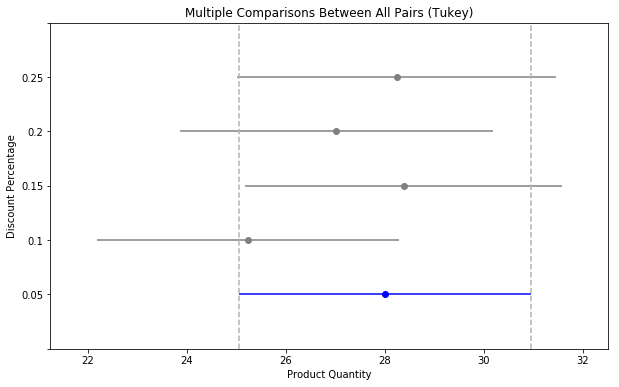

In [39]:
mc_discounts = MultiComparison(df_discounts.Quantity, df_discounts.Discount)
mc_discounts_upd = mc_discounts.tukeyhsd()
mc_discounts_upd.plot_simultaneous(comparison_name=0.05, figsize=(10,6), ylabel='Discount Percentage', xlabel='Product Quantity');

In [40]:
df_updated['avg_revenue'] = df_updated.UnitPrice * df_updated.Quantity * (1-df_updated.Discount)
df_updated

,ProductId,UnitPrice,Quantity,Discount,avg_revenue
0,11,14.00,12,0.0,168.0
1,42,9.80,10,0.0,98.0
2,72,34.80,5,0.0,174.0
3,14,18.60,9,0.0,167.4
4,51,42.40,40,0.0,1696.0
...,...,...,...,...,...
2147,52,7.00,2,0.0,14.0
2148,55,24.00,2,0.0,48.0
2151,66,17.00,1,0.0,17.0
2153,75,7.75,4,0.0,31.0


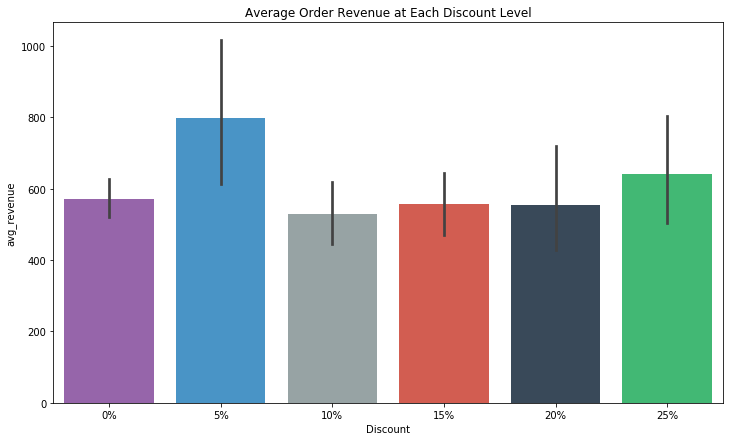

In [41]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
plt.figure(figsize=(12,7))
sns.barplot(x='Discount', y='avg_revenue', data=df_updated, palette=flatui)
plt.title("Average Order Revenue at Each Discount Level")
plt.xticks(np.arange(6), labels= ['0%', '5%', '10%', '15%', '20%', '25%'])
plt.show()

<a id="3.4"></a>

### 3.4 - Interpret Data

<br> We reject the null hypothesis for 1a and fail to reject the null hypothesis for 1b. 
<br> There is a significant difference between the number of products ordered between discounted and non-discounted items.
<br> The average amount of non-discounted items ordered is 21.8. 
<br> The average amount of discounted items ordered is 26.7. 
<br> The effect size is considered large. The observable and practical effect is significant.
<br> There is not a significant difference when comparing the levels of discounts offered vs items sold. 


<a id="3.6"></a>

<a id="004"></a>

## 4) Question #2
> ### "Does average product revenue have a statistically significant difference between regions?"
***

**4.1** - [Define Hypothesis](#4.1) 
<br>**4.2** - [Explore Data](#4.2) 
<br>**4.3** - [Test Data](#4.3) 
<br>**4.4** - [Interpret Data](#4.4)
<br>

<a id="4.1"></a>

### 4.1 Define Hypothesis

$H_O$: There is **NO** significant difference in revenue between regions.<br> 
$H_a$: There **IS** a significant difference in revenue between regions.<br> 
$\alpha$ = 0.05: The null hypothesis will be rejected if our P-value outcome is below this threshold. 

<a id="4.2"></a>

### 4.2 Explore Data

In [42]:
region_rev = pd.read_sql_query('''SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id''', engine)
region_rev.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [43]:
region_rev['total_revenue'] = region_rev.UnitPrice * region_rev.Quantity * (1 - region_rev.Discount)
region_rev = region_rev.drop(['UnitPrice','Quantity','Discount'], axis=1)
region_rev = region_rev.groupby(['Region','OrderId'])['total_revenue'].sum().reset_index()
region_rev = region_rev.drop('OrderId', axis=1)
region_rev.head()

,Region,total_revenue
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


In [44]:
region_rev.loc[(region_rev.Region == 'South America') | (region_rev.Region == 'Central America'), 'Region'] = 'South & Central America'
region_rev.loc[(region_rev.Region == 'Eastern Europe') | (region_rev.Region == 'Southern Europe'), 'Region'] = 'Eastern & Southern Europe'
region_rev.loc[(region_rev.Region == 'Northern Europe') | (region_rev.Region == 'Scandinavia'), 'Region'] = 'Scandinavia & Northern Europe'

In [45]:
region_rev.groupby('Region').count()

,total_revenue
Region,
British Isles,75
Eastern & Southern Europe,71
North America,152
Scandinavia & Northern Europe,83
South & Central America,148
Western Europe,272


In [46]:
W_Europe = region_rev[region_rev['Region'] == 'Western Europe'] 
N_America = region_rev[region_rev['Region'] == 'North America'] 
WE_NA = pd.concat([W_Europe, N_America], axis=0)
WE_NA

,Region,total_revenue
529,Western Europe,440.0000
530,Western Europe,1863.4000
531,Western Europe,654.0600
532,Western Europe,3597.9000
533,Western Europe,556.6200
...,...,...
250,North America,525.0000
251,North America,510.0000
252,North America,4330.4000
253,North America,928.7500


#### Visualize Relationships

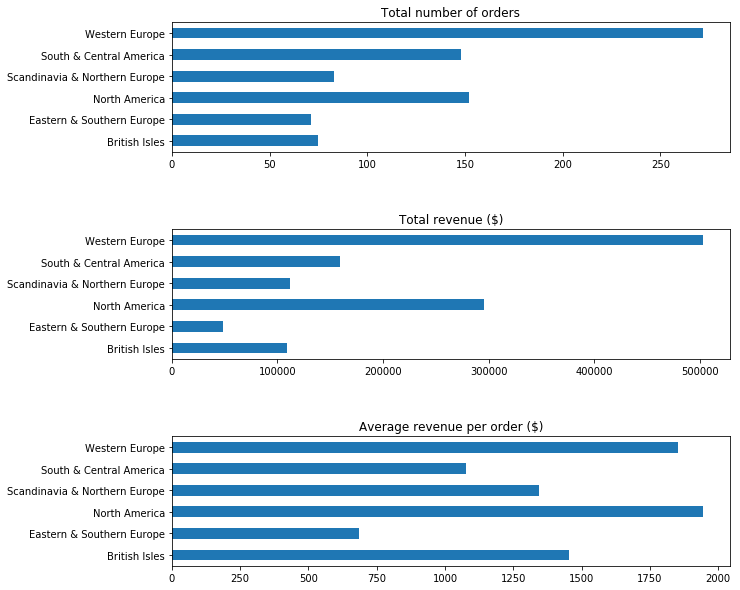

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))
region_rev.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
region_rev.groupby(['Region'])['total_revenue'].sum().plot(kind='barh', ax=ax2)
region_rev.groupby(['Region'])['total_revenue'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per order ($)')
ax3.set_ylabel('')
fig.subplots_adjust(hspace=0.6);

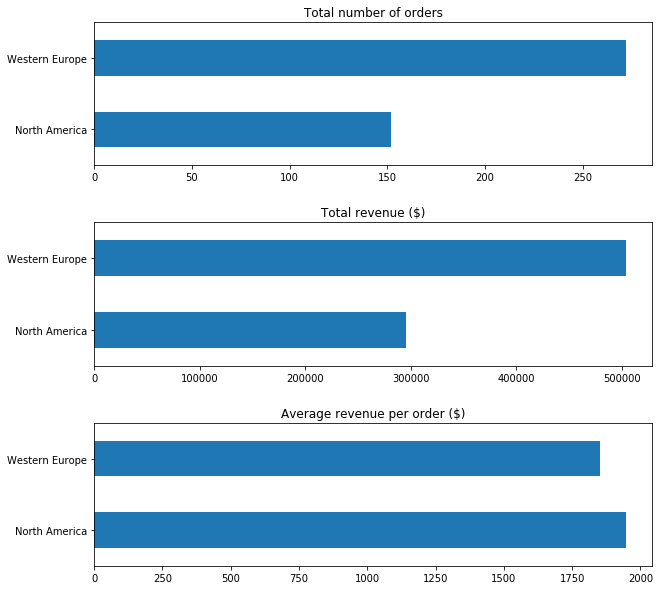

In [48]:
# Plotting the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))
WE_NA.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
WE_NA.groupby(['Region'])['total_revenue'].sum().plot(kind='barh', ax=ax2)
WE_NA.groupby(['Region'])['total_revenue'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per order ($)')
ax3.set_ylabel('')
fig.subplots_adjust(hspace=0.4);

<a id="4.3"></a>

### 4.3 Test Data

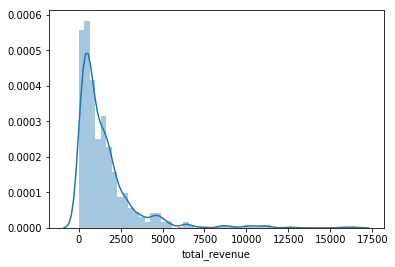

In [49]:
sns.distplot(region_rev.total_revenue);

In [50]:
st.shapiro(region_rev.total_revenue)
statistic, p = shapiro(region_rev.total_revenue)
print('Statistic=%.3f, p=%.3f' % (statistic, p))
alpha = .05
if p > alpha:
    print('Data looks normal')
else:
    print('Data does not look normal')

Statistic=0.666, p=0.000
Data does not look normal


In [51]:
k2, p = st.normaltest(region_rev.total_revenue)
print("p = {:g}".format(p))
alpha = 0.05
if p > alpha:  
    print('Data looks normal')
else:
    print('Data does not look normal')

p = 1.09603e-135
Data does not look normal


### Apply Central Limit Theorem

In [52]:
rr_test = get_sample(region_rev.total_revenue, 30)
print(rr_test[:5]) 

[252.0, 420.0, 708.75, 100.8, 459.0]


In [53]:
rr_test2 = get_sample(region_rev.total_revenue, 30)
rr_test2_mean = get_sample_mean(rr_test2)
print(rr_test2_mean) 

1801.9152166666665


In [54]:
test_rr_dist = create_sample_distribution(region_rev.total_revenue)
print(test_rr_dist[:5]) 

[1551.6403333333333, 1963.8006666666668, 980.8811666666664, 1524.2920000000004, 1680.6165]


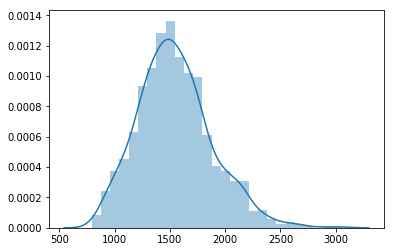

In [55]:
sample_rr_1000 = create_sample_distribution(region_rev.total_revenue, 1000, 30)
sns.distplot(sample_rr_1000);

In [56]:
t_stat, p = stats.ttest_ind(sample_rr_1000, W_Europe.total_revenue)

print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
print('P-Value:', p)

Reject Null Hypothesis
P-Value: 8.507683457568792e-06


In [57]:
t_stat, p = stats.ttest_ind(sample_rr_1000, N_America.total_revenue)

print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
print(p)

Reject Null Hypothesis
1.2038345491674104e-07


### ANOVA Test

In [58]:
formula = 'total_revenue ~ C(Region)'
lm = ols(formula, region_rev).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),1.386334e+08,5.0,8.469639,8.023836e-08
Residual,2.602556e+09,795.0,NaN,NaN


### Cohen's d

In [59]:
d = Cohen_d(region_rev.total_revenue, N_America.total_revenue)
print("Cohen's d:", d)


Cohen's d: 0.21585179571564916


0.10792589785782458
overlap 1.106
superiority 0.42


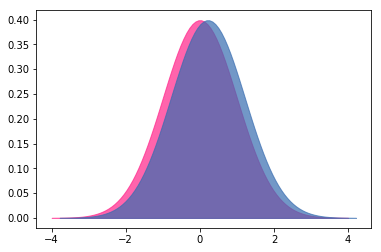

In [60]:
plot_pdfs(d)

<a id="4.4"></a>

### 4.4 Interpret Data

We reject the null hypothesis. 
<br> There is a significant difference in product revenue per order between regions. 
<br> Western European customers offer the greatest contribution to Northwind’s bottom line and also place the most orders. 
<br> North American customers spend slightly more per order although they only place half as many total orders as Western Europe. 
<br> The difference between the highest  and lowest regions is '$1,945' vs '$686.73' - nearly 3 times higher. 
<br> The effect size is not significant, however. 

<a id="005"></a>

## 5) Question #3
> ### "Is there a statistically significant difference in efficiency between shipping companies?"
***

**5.1** - [Define Hypothesis](#5.1) 
<br>**5.2** - [Explore Data](#5.2) 
<br>**5.3** - [Test Data](#5.3) 
<br>**5.4** - [Interpret Data](#5.4)
<br>

<a id="5.1"></a>

### 5.1 Define Hypothesis

$H_O$: Shipping companies have **NO** significant differences in efficiency.<br> 
$H_a$: Shipping companies **HAVE** significant differences in efficiency.<br> 
$\alpha$ = 0.05: The null hypothesis will be rejected if our P-value outcome is below this threshold.

<a id="5.2"></a>

### 5.2 Explore Data


In [61]:
shipper_order = pd.read_sql_query('''SELECT s.CompanyName, s.Id, o.ShippedDate, o.RequiredDate, o.OrderDate, o.ShipVia
    FROM [Order] o
    JOIN Shipper s ON o.ShipVia = s.Id''', engine)
shipper_order.head()

,CompanyName,Id,ShippedDate,RequiredDate,OrderDate,ShipVia
0,Federal Shipping,3,2012-07-16,2012-08-01,2012-07-04,3
1,Speedy Express,1,2012-07-10,2012-08-16,2012-07-05,1
2,United Package,2,2012-07-12,2012-08-05,2012-07-08,2
3,Speedy Express,1,2012-07-15,2012-08-05,2012-07-08,1
4,United Package,2,2012-07-11,2012-08-06,2012-07-09,2


In [62]:
shipper_order = shipper_order.drop('ShipVia', axis=1)

In [63]:
shipper_order.groupby('CompanyName').count()

,Id,ShippedDate,RequiredDate,OrderDate
CompanyName,,,,
Federal Shipping,255,249,255,255
Speedy Express,249,245,249,249
United Package,326,315,326,326


In [64]:
shipper_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 5 columns):
CompanyName     830 non-null object
Id              830 non-null int64
ShippedDate     809 non-null object
RequiredDate    830 non-null object
OrderDate       830 non-null object
dtypes: int64(1), object(4)
memory usage: 32.5+ KB


In [65]:
shipper_order['ShippedDate'] = pd.to_datetime(shipper_order['ShippedDate'], format="%Y/%m/%d") 
shipper_order['RequiredDate'] = pd.to_datetime(shipper_order['RequiredDate'], format="%Y/%m/%d") 
shipper_order['OrderDate'] = pd.to_datetime(shipper_order['OrderDate'], format="%Y/%m/%d")

In [66]:
ShippedDate = pd.to_datetime(shipper_order['ShippedDate'], format="%Y/%m/%d") 
RequiredDate = pd.to_datetime(shipper_order['RequiredDate'], format="%Y/%m/%d") 
OrderDate = pd.to_datetime(shipper_order['OrderDate'], format="%Y/%m/%d")

In [67]:
OrderDate

0     2012-07-04
1     2012-07-05
2     2012-07-08
3     2012-07-08
4     2012-07-09
         ...    
825   2014-05-05
826   2014-05-06
827   2014-05-06
828   2014-05-06
829   2014-05-06
Name: OrderDate, Length: 830, dtype: datetime64[ns]

In [68]:
from datetime import datetime

end_date = pd.to_datetime(ShippedDate)
start_date = pd.to_datetime(OrderDate)
time_order_ship = abs((end_date - start_date))

time_order_ship.value_counts()

7 days     108
6 days      91
8 days      71
3 days      70
9 days      70
5 days      65
4 days      63
2 days      58
10 days     53
12 days     19
1 days      18
11 days     14
21 days      9
29 days      8
13 days      7
19 days      7
32 days      7
20 days      6
15 days      6
14 days      6
17 days      5
25 days      5
35 days      5
18 days      5
23 days      5
34 days      4
30 days      4
22 days      4
26 days      3
24 days      3
28 days      3
37 days      2
31 days      2
27 days      2
16 days      1
dtype: int64

In [69]:
shipper_order['time_order_ship'] = time_order_ship

In [70]:
shipper_order = shipper_order.dropna()

In [71]:
shipper_order.isna().sum()

CompanyName        0
Id                 0
ShippedDate        0
RequiredDate       0
OrderDate          0
time_order_ship    0
dtype: int64

In [72]:
shipper_order

,CompanyName,Id,ShippedDate,RequiredDate,OrderDate,time_order_ship
0,Federal Shipping,3,2012-07-16,2012-08-01,2012-07-04,12 days
1,Speedy Express,1,2012-07-10,2012-08-16,2012-07-05,5 days
2,United Package,2,2012-07-12,2012-08-05,2012-07-08,4 days
3,Speedy Express,1,2012-07-15,2012-08-05,2012-07-08,7 days
4,United Package,2,2012-07-11,2012-08-06,2012-07-09,2 days
...,...,...,...,...,...,...
815,United Package,2,2014-05-06,2014-05-28,2014-04-30,6 days
816,Speedy Express,1,2014-05-04,2014-05-29,2014-05-01,3 days
818,United Package,2,2014-05-04,2014-05-29,2014-05-01,3 days
819,United Package,2,2014-05-06,2014-05-18,2014-05-04,2 days


In [73]:
Speedy_Express = shipper_order[(shipper_order['Id'] == 1)]
United_Package = shipper_order[(shipper_order['Id']==2)]
Federal_Shipping = shipper_order[shipper_order['Id']==3]

In [74]:
Speedy_Ex = Speedy_Express['time_order_ship']
United_Pack = United_Package['time_order_ship']
Federal_Ship = Federal_Shipping['time_order_ship']
Speedy_Ex

1      5 days
3      7 days
10     6 days
12    10 days
17    18 days
        ...  
794    9 days
796    8 days
801   10 days
804    4 days
816    3 days
Name: time_order_ship, Length: 245, dtype: timedelta64[ns]

In [75]:
Speedy_Ex = Speedy_Ex.rename('Speedy')
United_Pack = United_Pack.rename('United')
Federal_Ship = Federal_Ship.rename('Federal')
Speedy_Ex

1      5 days
3      7 days
10     6 days
12    10 days
17    18 days
        ...  
794    9 days
796    8 days
801   10 days
804    4 days
816    3 days
Name: Speedy, Length: 245, dtype: timedelta64[ns]

In [76]:
Speedy_graph = Speedy_Ex.astype('timedelta64[h]')
United_graph = United_Pack.astype('timedelta64[h]')
Federal_graph = Federal_Ship.astype('timedelta64[h]')

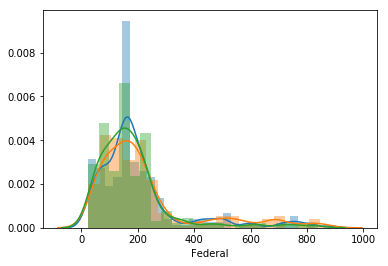

In [77]:
sns.distplot(Speedy_graph, label='Speedy Express');
sns.distplot(United_graph, label='United Package');
sns.distplot(Federal_graph, label='Federal Shipping');

In [78]:
shipping_duration = pd.concat([Speedy_graph, United_graph, Federal_graph], axis=1)
avg_duration = {'Speedy':(shipping_duration.Speedy.mean() / 24),
                'United':(shipping_duration.United.mean() / 24),
                'Federal':(shipping_duration.Federal.mean() / 24)}
shipping_duration

,Speedy,United,Federal
0,NaN,NaN,288.0
1,120.0,NaN,NaN
2,NaN,96.0,NaN
3,168.0,NaN,NaN
4,NaN,48.0,NaN
...,...,...,...
815,NaN,144.0,NaN
816,72.0,NaN,NaN
818,NaN,72.0,NaN
819,NaN,48.0,NaN


In [79]:
S_mean = (shipping_duration.Speedy.mean() / 24)
U_mean = (shipping_duration.United.mean() / 24)
F_mean = (shipping_duration.Federal.mean() / 24)
ship_mean = pd.DataFrame([S_mean,U_mean,F_mean]).reset_index()
ship_mean

,index,0
0,0,8.571429
1,1,9.234921
2,2,7.473896


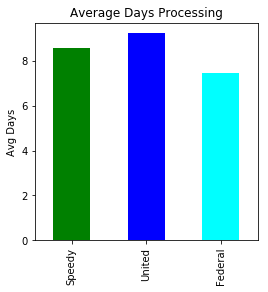

In [80]:
plt.figure(figsize=(4,4))
ship_mean[0].plot(kind='bar', color=['green','blue','cyan'])
plt.title('Average Days Processing')
plt.ylabel('Avg Days')

plt.xticks(np.arange(3), labels=['Speedy','United','Federal'])
plt.show()

In [81]:
# t_stat, p = stats.ttest_ind(shipping_duration, Speedy_Ex.Speedy)

# print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
# print(p)

### Percentage of Late Shipments

In [82]:
from datetime import timedelta
end_date2 = pd.to_datetime(RequiredDate)
start_date2 = pd.to_datetime(ShippedDate)
ship_required = (end_date2 - start_date2)
t = timedelta(minutes=0)
late_shipments = pd.DataFrame(x for x in ship_required if x < t)


In [83]:
shipper_order['LateShipments'] = late_shipments

In [84]:
shipper_order

,CompanyName,Id,ShippedDate,RequiredDate,OrderDate,time_order_ship,LateShipments
0,Federal Shipping,3,2012-07-16,2012-08-01,2012-07-04,12 days,-2 days
1,Speedy Express,1,2012-07-10,2012-08-16,2012-07-05,5 days,-1 days
2,United Package,2,2012-07-12,2012-08-05,2012-07-08,4 days,-1 days
3,Speedy Express,1,2012-07-15,2012-08-05,2012-07-08,7 days,-1 days
4,United Package,2,2012-07-11,2012-08-06,2012-07-09,2 days,-6 days
...,...,...,...,...,...,...,...
815,United Package,2,2014-05-06,2014-05-28,2014-04-30,6 days,NaT
816,Speedy Express,1,2014-05-04,2014-05-29,2014-05-01,3 days,NaT
818,United Package,2,2014-05-04,2014-05-29,2014-05-01,3 days,NaT
819,United Package,2,2014-05-06,2014-05-18,2014-05-04,2 days,NaT


In [85]:
late_count = shipper_order.groupby(['CompanyName'])['LateShipments'].count().reset_index()
late_total = shipper_order.groupby(['CompanyName'])['LateShipments'].sum().reset_index()


In [86]:
Speedy_Express_late = (late_count.LateShipments[0] / len(Speedy_Express)) * 100
United_Package_late = (late_count.LateShipments[1] / len(United_Package)) * 100
Federal_Shipping_late = (late_count.LateShipments[2] / len(Federal_Shipping)) * 100
late_list = pd.DataFrame([Speedy_Express_late, United_Package_late, Federal_Shipping_late]).reset_index()
late_list

,index,0
0,0,5.306122
1,1,4.444444
2,2,4.016064


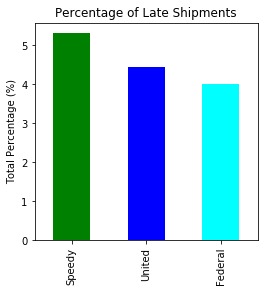

In [87]:
plt.figure(figsize=(4,4))
late_list[0].plot(kind='bar', color=['green','blue','cyan'])
plt.title('Percentage of Late Shipments')
plt.ylabel('Total Percentage (%)')

plt.xticks(np.arange(3), labels=['Speedy','United','Federal'])
plt.show()

<a id="5.3"></a>

### 5.3 Test Data

In [88]:
# formula = 'ProcessingTime ~ C(ShipVia)'
# lm = ols(formula, Order_df).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

<a id="5.4"></a>

### 5.4 Interpret Data

Although there is an observable difference, we cannot reject the null hypothesis. 
<br> Federal Shipping has a slight advantage in decreased time from the moment an order is placed to the time it is shipped. 
<br> Federal Shipping also has a lower percentage of late shipments. 
<br> From an efficiency perspective, Federal Shipping performs better than the other two. 
<br> Next study will compare cost vs efficiency. 


<a id="006"></a>

## 6) Question #4
> ### "Does the best selling product category differ significantly between regions?"
***

**6.1** - [Define Hypothesis](#6.1) 
<br>**6.2** - [Explore Data](#6.2) 
<br>**6.3** - [Test Data](#6.3) 
<br>**6.4** - [Interpret Data](#6.4)
<br>

<a id="6.1"></a>

### 6.1 Define Hypothesis

$H_O$: There is **NO** significant difference in product category popularity between regions.<br> 
$H_a$: There **IS** significant difference in product category popularity between regions.<br> 
$\alpha$ = 0.05: The null hypothesis will be rejected if our P-value outcome is below this threshold.

<a id="6.2"></a>

### 6.2 Explore Data

In [89]:
cat_region = pd.read_sql_query('''SELECT OD.Quantity, OD.Discount, OD.UnitPrice, O.ShipRegion, P.CategoryId, P.ProductName 
                                FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product AS P
                                ON P.Id = OD.ProductId
                                ''', engine)   

In [90]:
cat_region['total_rev'] = cat_region.UnitPrice * cat_region.Quantity * (1 - cat_region.Discount)
cat_region = cat_region.drop(['UnitPrice','Quantity','Discount', 'ProductName'], axis=1)
cat_region

,ShipRegion,CategoryId,total_rev
0,Western Europe,4,168.000
1,Western Europe,5,98.000
2,Western Europe,4,174.000
3,Western Europe,7,167.400
4,Western Europe,7,1696.000
...,...,...,...
2150,North America,5,64.505
2151,North America,2,17.000
2152,North America,8,29.700
2153,North America,1,31.000


In [91]:
cat_region_1 = cat_region.groupby(['CategoryId', 'ShipRegion'])['total_rev'].sum()
cat_region_2 = cat_region.groupby(['CategoryId', 'ShipRegion']).count()
cat_region_3 = cat_region.groupby(['CategoryId', 'ShipRegion'])['total_rev'].mean()

In [92]:
Beverages = cat_region.loc[(cat_region.CategoryId==1)]
Condiments = cat_region.loc[(cat_region.CategoryId==2)]
Confections = cat_region.loc[(cat_region.CategoryId==3)]
Dairy = cat_region.loc[(cat_region.CategoryId==4)]
Grains_Cereal = cat_region.loc[(cat_region.CategoryId==5)]
Meat_Poultry = cat_region.loc[(cat_region.CategoryId==6)]
Produce = cat_region.loc[(cat_region.CategoryId==7)]
Seafood = cat_region.loc[(cat_region.CategoryId==8)]


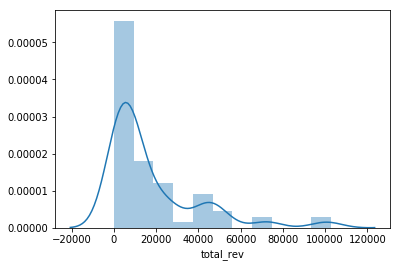

In [93]:
sns.distplot(cat_region_1);

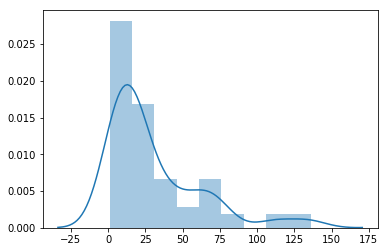

In [94]:
sns.distplot(cat_region_2);

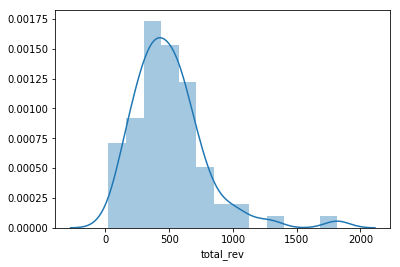

In [95]:
sns.distplot(cat_region_3);

In [96]:
cat_region

,ShipRegion,CategoryId,total_rev
0,Western Europe,4,168.000
1,Western Europe,5,98.000
2,Western Europe,4,174.000
3,Western Europe,7,167.400
4,Western Europe,7,1696.000
...,...,...,...
2150,North America,5,64.505
2151,North America,2,17.000
2152,North America,8,29.700
2153,North America,1,31.000


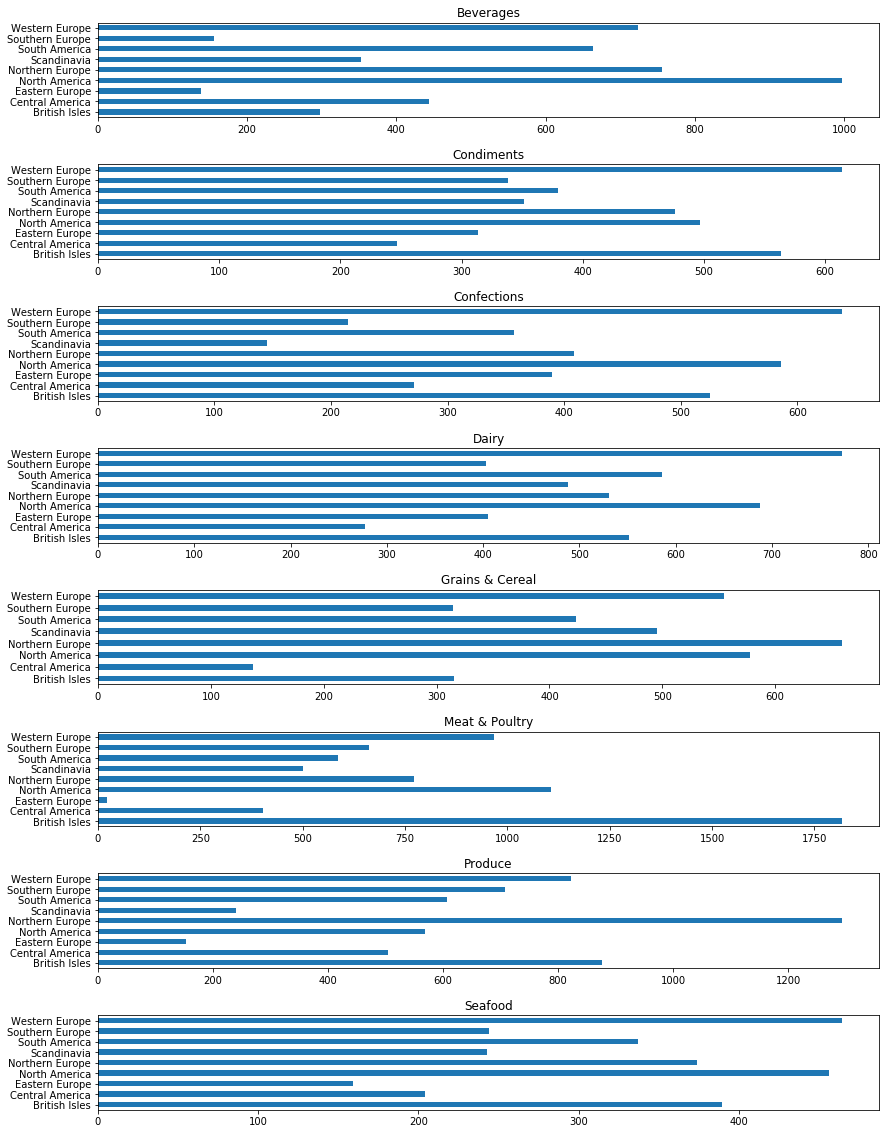

In [97]:
# Plotting the number of orders, total revenue per order and average revenue per order for each region
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(14,20))
Beverages.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax1)
Condiments.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax2)
Confections.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax3)
Dairy.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax4)
Grains_Cereal.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax5)
Meat_Poultry.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax6)
Produce.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax7)
Seafood.groupby(['ShipRegion'])['total_rev'].mean().plot(kind='barh', ax=ax8)
ax1.set_title('Beverages')
ax1.set_ylabel('')
ax2.set_title('Condiments')
ax2.set_ylabel('')
ax3.set_title('Confections')
ax3.set_ylabel('')
ax4.set_title('Dairy')
ax4.set_ylabel('')
ax5.set_title('Grains & Cereal')
ax5.set_ylabel('')
ax6.set_title('Meat & Poultry')
ax6.set_ylabel('')
ax7.set_title('Produce')
ax7.set_ylabel('')
ax8.set_title('Seafood')
ax8.set_ylabel('')
fig.subplots_adjust(hspace=.5);

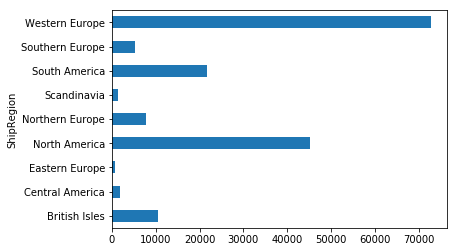

In [98]:
Confections.groupby(['ShipRegion'])['total_rev'].sum().plot(kind='barh');

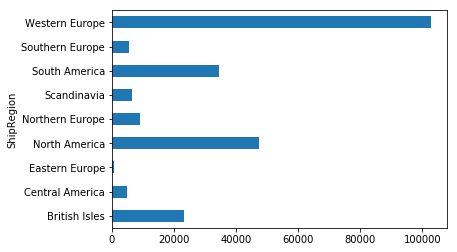

In [99]:
Dairy.groupby(['ShipRegion'])['total_rev'].sum().plot(kind='barh');

<a id="6.3"></a>

### 6.3 Test Data

In [100]:
formula = 'total_rev ~ C(ShipRegion)'
lm = ols(formula, Beverages).fit()
table1 = sm.stats.anova_lm(lm, typ=2)
print('\nBeverages:\n', table1)

lm = ols(formula, Condiments).fit()
table2 = sm.stats.anova_lm(lm, typ=2)
print('\nCondiments:\n', table2)

lm = ols(formula, Confections).fit()
table3 = sm.stats.anova_lm(lm, typ=2)
print('\nConfections:\n', table3)

lm = ols(formula, Dairy).fit()
table4 = sm.stats.anova_lm(lm, typ=2)
print('\nDairy:\n', table4)

lm = ols(formula, Grains_Cereal).fit()
table5 = sm.stats.anova_lm(lm, typ=2)
print('\nGrains & Cereal:\n', table5)

lm = ols(formula, Meat_Poultry).fit()
table6 = sm.stats.anova_lm(lm, typ=2)
print('\nMeat & Poultry:\n', table6)

lm = ols(formula, Produce).fit()
table7 = sm.stats.anova_lm(lm, typ=2)
print('\nProduce:\n', table7)

lm = ols(formula, Seafood).fit()
table8 = sm.stats.anova_lm(lm, typ=2)
print('\nSeafood:\n', table8)


Beverages:
                      sum_sq     df         F    PR(>F)
C(ShipRegion)  2.304220e+07    8.0  1.013759  0.424856
Residual       1.122268e+09  395.0       NaN       NaN

Condiments:
                      sum_sq     df         F    PR(>F)
C(ShipRegion)  2.538756e+06    8.0  1.513332  0.154133
Residual       4.340774e+07  207.0       NaN       NaN

Confections:
                      sum_sq     df         F    PR(>F)
C(ShipRegion)  7.730153e+06    8.0  2.626665  0.008449
Residual       1.195575e+08  325.0       NaN       NaN

Dairy:
                      sum_sq     df         F    PR(>F)
C(ShipRegion)  6.627198e+06    8.0  1.760274  0.083689
Residual       1.680072e+08  357.0       NaN       NaN

Grains & Cereal:
                      sum_sq     df         F    PR(>F)
C(ShipRegion)  2.587505e+06    7.0  1.322002  0.241882
Residual       5.256648e+07  188.0       NaN       NaN

Meat & Poultry:
                      sum_sq     df         F    PR(>F)
C(ShipRegion)  2.090162e+07    8

<a id="6.4"></a>

### 6.4 Interpret Data

Only two categories showed a significant difference between regions: Confections and Dairy.
Since we didn't specify if only a specific region affects the null hypothesis, we must reject the null hypothesis based off even one category showing significance. 